In [1]:
import numpy as np
import xarray as xr
import xrft
import gsw
import os.path as op
from dask.array import fft
from dask.diagnostics import ProgressBar
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

In [3]:
ys, dy = (58,20)
dt = 12e2
ts = int((ys*360*86400)/8e2 + 9*360*86400/dt)
te = int(ts + (dy*360*86400)/dt)
print(ts,te)

2488320 3006720


In [27]:
dsnap = open_mdsdataset(op.join(ddir,'Phys-only_20km'), grid_dir=op.join(ddir,'20km_grid'),
                       iters=range(ts,te,1080), prefix=['MOMsnap'], delta_t=dt
                       )
dsnap

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/Phys-only_20km. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (XC: 50, XG: 50, YC: 100, YG: 100, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 480)
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG       (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dxG      (YG, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dyG      (YC, XG) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    Depth    (YC, XC) >f4 dask

In [28]:
grid = Grid(dsnap, periodic=['X'])
phi = dsnap.PHIHYD
b = (grid.diff(phi,'Z',boundary='fill')/grid.diff(phi.Z,'Z',boundary='fill'))
b

<xarray.DataArray (time: 480, Zl: 40, YC: 100, XC: 50)>
dask.array<shape=(480, 40, 100, 50), dtype=float32, chunksize=(1, 1, 100, 50)>
Coordinates:
  * time     (time) float64 2.986e+09 2.987e+09 2.989e+09 2.99e+09 2.991e+09 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...

In [29]:
u = dsnap.UVEL
v = dsnap.VVEL
w = dsnap.WVEL

In [30]:
uk = xrft.dft(u, dim=['XG'], shift=False)
vk = xrft.dft(v, dim=['XC'], shift=False)
wk = xrft.dft(w, dim=['XC'], shift=False)
bk = xrft.dft(b, dim=['XC'], shift=False)
with ProgressBar():
    ux = xr.DataArray(fft.ifft((2j*np.pi*uk*uk.freq_XG).data, axis=-1).real, dims=u.dims, coords=u.coords).compute()
    vx = xr.DataArray(fft.ifft((2j*np.pi*vk*vk.freq_XC).data, axis=-1).real, dims=v.dims, coords=v.coords).compute()
    wx = xr.DataArray(fft.ifft((2j*np.pi*wk*wk.freq_XC).data, axis=-1).real, dims=w.dims, coords=w.coords).compute()
    bx = xr.DataArray(fft.ifft((2j*np.pi*bk*bk.freq_XC).data, axis=-1).real, dims=b.dims, coords=b.coords).compute()
uy = grid.diff(u, 'Y', boundary='fill')/grid.diff(u.YC, 'Y', boundary='fill')
vy = grid.diff(v, 'Y', boundary='fill')/grid.diff(v.YG, 'Y', boundary='fill')
wy = grid.diff(w, 'Y', boundary='fill')/grid.diff(w.YC, 'Y', boundary='fill')
by = grid.diff(b, 'Y', boundary='fill')/grid.diff(b.YC, 'Y', boundary='fill')
bz = grid.diff(b, 'Z', boundary='fill')/grid.diff(b.Zl, 'Z', boundary='fill')

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed | 23.6s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  5.0s


In [31]:
qs1 = (grid.interp(ux,'X')*grid.interp(bx,'Z',boundary='fill') 
      + grid.interp(vx,'Y',boundary='fill')*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(wx,'Z',boundary='fill')*bz
      )
qs2 = (grid.interp(grid.interp(uy,'X'),'Y',boundary='fill')*grid.interp(bx,'Z',boundary='fill')
      + vy*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      + grid.interp(grid.interp(wy,'Y',boundary='fill'),'Z',boundary='fill')*bz
      )

In [32]:
Fs = -(qs1*grid.interp(bx,'Z',boundary='fill') 
      + qs2*grid.interp(grid.interp(by,'Y',boundary='fill'),'Z',boundary='fill')
      )
Fs

<xarray.DataArray (time: 480, Z: 40, YC: 100, XC: 50)>
dask.array<shape=(480, 40, 100, 50), dtype=float64, chunksize=(1, 1, 1, 50)>
Coordinates:
  * time     (time) float64 2.986e+09 2.987e+09 2.989e+09 2.99e+09 2.991e+09 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...

In [33]:
Fs.coords['day'] = ('time',np.tile(range(24),dy))
with ProgressBar():
    Fsd = np.abs(Fs).sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
Fsd

[########################################] | 100% Completed | 59.3s


<xarray.DataArray (day: 24, Z: 40)>
array([[5.751024e-17, 4.022514e-22, 3.970907e-22, ..., 8.910955e-25,
        2.639704e-25, 1.238100e-24],
       [5.295659e-17, 3.867768e-22, 3.824664e-22, ..., 8.610103e-25,
        2.529749e-25, 1.202354e-24],
       [5.190768e-17, 4.111673e-22, 4.038671e-22, ..., 8.640673e-25,
        2.620218e-25, 1.244908e-24],
       ...,
       [9.077432e-17, 4.400287e-22, 4.375842e-22, ..., 8.455311e-25,
        2.406307e-25, 1.193269e-24],
       [7.992003e-17, 4.322502e-22, 4.281634e-22, ..., 8.554011e-25,
        2.409068e-25, 1.233086e-24],
       [6.694275e-17, 4.181858e-22, 4.124276e-22, ..., 8.864188e-25,
        2.478385e-25, 1.187763e-24]])
Coordinates:
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [35]:
zeta = grid.interp(vx,'X')-uy
zeta

<xarray.DataArray (time: 480, Z: 40, YG: 100, XG: 50)>
dask.array<shape=(480, 40, 100, 50), dtype=float64, chunksize=(1, 40, 1, 50)>
Coordinates:
  * time     (time) float64 2.986e+09 2.987e+09 2.989e+09 2.99e+09 2.991e+09 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * YG       (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...

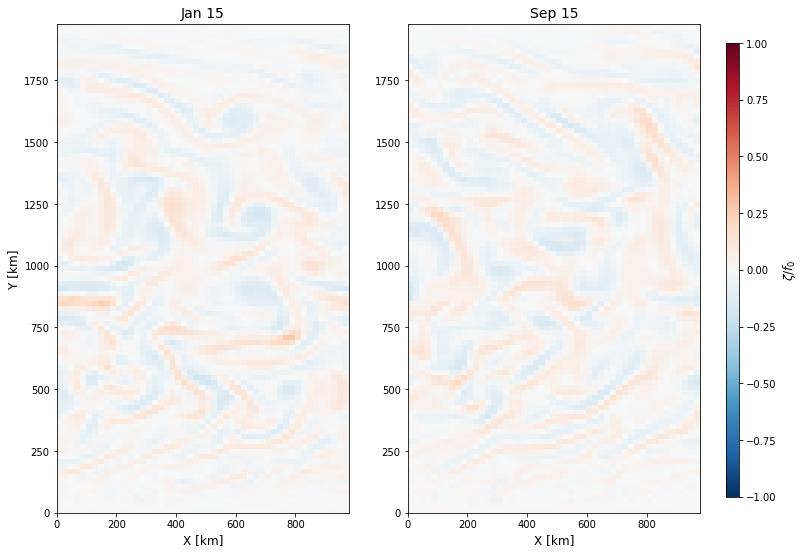

In [36]:
f0 = -1.1e-4

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,9))
im = ax1.pcolormesh(zeta.XG*1e-3, zeta.YG*1e-3, zeta[-24:][1,0]*f0**-1,
                   vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax2.pcolormesh(zeta.XG*1e-3, zeta.YG*1e-3, zeta[-24:][17,0]*f0**-1,
              vmax=1e0, vmin=-1e0, cmap='RdBu_r', rasterized=True)

ax1.set_ylabel(r'Y [km]', fontsize=12)
ax1.set_xlabel(r'X [km]', fontsize=12)
# ax2.set_ylabel(r'Y [km]', fontsize=12)
ax2.set_xlabel(r'X [km]', fontsize=12)
ax1.set_title(r"Jan 15",fontsize=14)
ax2.set_title(r"Sep 15",fontsize=14)
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\zeta/f_0$", fontsize=12)
plt.savefig(op.join(ddir,'Figures/zeta_20km_snap_Jan-Sep.pdf'))

In [37]:
dsave = Fs.to_dataset(name='Fs')
dsave['zeta'] = zeta
dsave.to_netcdf(op.join(ddir,'zeta-Fs_20kmrun.nc'))

In [39]:
seas = ('time',np.tile(np.repeat(range(4),6),dy))
zeta.coords['seas'] = seas
grouped = (zeta[:,0].sel(YG=slice(6e5,14e5))*f0**-1).groupby('seas')
da = xr.DataArray(np.zeros((4,6*dy,41,50)), dims=['seas','time','YG','XG'],
                 coords={'seas':range(4),'time':range(6*dy),
                         'YG':zeta.YG.sel(YG=slice(6e5,14e5)).data,'XG':zeta.XG.data}
                 )
i = 0
for group in grouped:
#     print(group)
    da[i] = group[1].data
    i += 1
da

<xarray.DataArray (seas: 4, time: 120, YG: 41, XG: 50)>
array([[[[ 0.038145, ..., -0.011076],
         ...,
         [ 0.051265, ...,  0.047152]],

        ...,

        [[ 0.022319, ...,  0.059683],
         ...,
         [ 0.088617, ...,  0.049514]]],


       ...,


       [[[ 0.003386, ..., -0.049309],
         ...,
         [-0.015685, ...,  0.001443]],

        ...,

        [[ 0.075657, ...,  0.051912],
         ...,
         [-0.016357, ...,  0.022734]]]])
Coordinates:
  * seas     (seas) int64 0 1 2 3
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * YG       (YG) >f4 600000.0 620000.0 640000.0 660000.0 680000.0 700000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


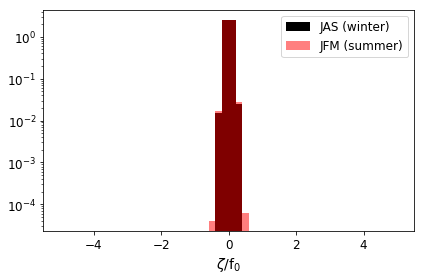

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)
ax.hist(da[2].data.ravel(), color='black', alpha=1., bins=50, range=(-5,5), 
        log=True, density=True, label='JAS (winter)')
ax.hist(da[0].data.ravel(), color='red', alpha=.5, bins=50, range=(-5,5), 
        log=True, density=True, label='JFM (summer)')
ax.set_xlabel(r"$\zeta$/f$_0$", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(op.join(ddir,'Figures/zeta_histogram_20km.pdf'))

In [6]:
dsave = open_mdsdataset(op.join(ddir,'Phys-only_20km'), grid_dir=op.join(ddir,'20km_grid'),
                       iters=range(ts+72,te+72,72), prefix=['MOMtave','KPPboundary'], delta_t=dt
                       )
dsave

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/Phys-only_20km. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:   (XC: 50, XG: 50, YC: 100, YG: 100, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 7200)
Coordinates:
  * XC        (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC        (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG        (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG        (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA        (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dxG       (YG, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dyG       (YC, XG) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    Depth     (YC

In [7]:
dsave.coords['days'] = ('time',np.tile(range(360),dy))
with ProgressBar():
    Tday = dsave.THETA.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC']).compute()
Tday

[########################################] | 100% Completed | 11min  4.2s


<xarray.DataArray 'THETA' (days: 360, Z: 40)>
array([[ 4.058547,  4.055637,  4.051739, ..., -0.136045, -0.15107 , -0.155022],
       [ 4.067031,  4.064116,  4.060198, ..., -0.136042, -0.151064, -0.155017],
       [ 4.075511,  4.072592,  4.068654, ..., -0.136038, -0.151059, -0.155012],
       ...,
       [ 4.032527,  4.029634,  4.025797, ..., -0.133446, -0.148396, -0.152332],
       [ 4.041077,  4.038177,  4.034316, ..., -0.13344 , -0.148389, -0.152326],
       [ 4.049617,  4.046711,  4.042825, ..., -0.133433, -0.148382, -0.152321]],
      dtype=float32)
Coordinates:
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 16.0 19.0 22.0 26.0 30.0 36.0 ...
    PHrefC   (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 799.515 ...
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [8]:
Tday.to_dataset(name='Tb').to_netcdf(op.join(ddir,'SSTb_20km.nc'))

In [7]:
f0 = -1.1e-4
beta = 1.4e-11
fC = f0 + beta*(dsave.YC-10e5).sel(YC=slice(5.5e5,14.5e5))
fG = f0 + beta*(dsave.YG-10e5).sel(YG=slice(5.5e5,14.5e5))
g = 9.81
r0 = 1e3
alpha = 2e-4

with ProgressBar():
    pt = dsave.THETA.sel(YC=slice(5e5,15e5)).load()

[########################################] | 100% Completed | 20min 27.3s


In [8]:
grid = Grid(dsave, periodic=['X'])
N2 = alpha*g * (grid.diff(pt,'Z',boundary='extend',to='outer')
                / grid.diff(pt.Z,'Z',boundary='fill',to='outer')
               )
N2

<xarray.DataArray (time: 7200, Zp1: 41, YC: 50, XC: 50)>
array([[[[-0., ..., -0.],
         ...,
         [-0., ..., -0.]],

        ...,

        [[ 0., ...,  0.],
         ...,
         [ 0., ...,  0.]]],


       ...,


       [[[-0., ..., -0.],
         ...,
         [-0., ..., -0.]],

        ...,

        [[ 0., ...,  0.],
         ...,
         [ 0., ...,  0.]]]], dtype=float32)
Coordinates:
  * time     (time) float64 2.986e+09 2.986e+09 2.986e+09 2.986e+09 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * YC       (YC) >f4 510000.0 530000.0 550000.0 570000.0 590000.0 610000.0 ...
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...

In [9]:
N2.coords['days'] = ('time',np.tile(range(360),dy))
with ProgressBar():
    N2day = N2.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC'])
N2day

<xarray.DataArray (days: 360, Zp1: 41)>
array([[0.000000e+00, 5.709041e-07, 7.647022e-07, ..., 2.861880e-07,
        7.528736e-08, 0.000000e+00],
       [0.000000e+00, 5.718443e-07, 7.687029e-07, ..., 2.861558e-07,
        7.528850e-08, 0.000000e+00],
       [0.000000e+00, 5.726679e-07, 7.726674e-07, ..., 2.861311e-07,
        7.530354e-08, 0.000000e+00],
       ...,
       [0.000000e+00, 5.677389e-07, 7.527503e-07, ..., 2.847744e-07,
        7.498129e-08, 0.000000e+00],
       [0.000000e+00, 5.689761e-07, 7.575867e-07, ..., 2.847558e-07,
        7.499795e-08, 0.000000e+00],
       [0.000000e+00, 5.702216e-07, 7.624970e-07, ..., 2.847600e-07,
        7.501625e-08, 0.000000e+00]], dtype=float32)
Coordinates:
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [88]:
N2day.Zp1[:nZ]

<xarray.DataArray 'Zp1' (Zp1: 19)>
array([   0.,  -10.,  -20.,  -30.,  -42.,  -56.,  -72.,  -91., -113., -139.,
       -169., -205., -247., -297., -357., -429., -514., -616., -719.],
      dtype=float32)
Coordinates:
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
Attributes:
    standard_name:      depth_at_w_location
    long_name:          vertical coordinate of cell interface
    units:              m
    positive:           down
    axis:               Z
    c_grid_axis_shift:  (-0.5, 0.5)

In [10]:
nZ = 18
nMLDN2 = np.argmax(N2[:,:nZ],axis=1)
nMLDT = np.argmin(np.abs(np.abs(-pt+pt[:,0])-0.2), axis=1)
nMLDT

<xarray.DataArray 'THETA' (time: 7200, YC: 50, XC: 50)>
array([[[3, 3, ..., 3, 3],
        [3, 3, ..., 3, 3],
        ...,
        [5, 5, ..., 4, 4],
        [4, 3, ..., 4, 4]],

       [[3, 3, ..., 3, 3],
        [3, 3, ..., 4, 3],
        ...,
        [4, 5, ..., 3, 3],
        [4, 4, ..., 4, 4]],

       ...,

       [[3, 3, ..., 4, 4],
        [3, 3, ..., 3, 3],
        ...,
        [4, 3, ..., 3, 4],
        [4, 3, ..., 4, 4]],

       [[3, 3, ..., 3, 4],
        [3, 3, ..., 3, 3],
        ...,
        [4, 4, ..., 4, 4],
        [4, 3, ..., 3, 4]]])
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 510000.0 530000.0 550000.0 570000.0 590000.0 610000.0 ...
    rA       (YC, XC) >f4 400000000.0 400000000.0 400000000.0 400000000.0 ...
    Depth    (YC, XC) >f4 2985.0 2985.0 2985.0 2985.0 2985.0 2985.0 2985.0 ...
    iter     (time) int64 2488392 2488464 2488536 2488608 2488680 2488752 ...
  * time     (time) float64 2.986e+0

In [11]:
zz = xr.DataArray(dsave.Zp1.data[np.newaxis,:,np.newaxis,np.newaxis]
                 * np.ones((7200,50,50))[:,np.newaxis,:,:],
                 dims=['time','Zp1','YC','XC'])
MLDN2 = zz.isel(Zp1=nMLDN2)
MLDN2.coords['days'] = ('time',np.tile(range(360),dy))
MLDT = zz.isel(Zp1=nMLDT)
MLDT.coords['days'] = ('time',np.tile(range(360),dy))
MLDT

<xarray.DataArray (time: 7200, YC: 50, XC: 50)>
array([[[-30., -30., ..., -30., -30.],
        [-30., -30., ..., -30., -30.],
        ...,
        [-56., -56., ..., -42., -42.],
        [-42., -30., ..., -42., -42.]],

       [[-30., -30., ..., -30., -30.],
        [-30., -30., ..., -42., -30.],
        ...,
        [-42., -56., ..., -30., -30.],
        [-42., -42., ..., -42., -42.]],

       ...,

       [[-30., -30., ..., -42., -42.],
        [-30., -30., ..., -30., -30.],
        ...,
        [-42., -30., ..., -30., -42.],
        [-42., -30., ..., -42., -42.]],

       [[-30., -30., ..., -30., -42.],
        [-30., -30., ..., -30., -30.],
        ...,
        [-42., -42., ..., -42., -42.],
        [-42., -30., ..., -30., -42.]]])
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 510000.0 530000.0 550000.0 570000.0 590000.0 610000.0 ...
    rA       (YC, XC) >f4 400000000.0 400000000.0 400000000.0 400000000.0 ...
    Depth

In [13]:
with ProgressBar():
    MLDN2day = MLDN2.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC']).compute()
    MLDTday = MLDT.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC']).compute()
MLDTday

<xarray.DataArray (days: 360)>
array([-53.01875 , -51.5843  , -50.21035 , ..., -58.713025, -56.7114  ,
       -54.841475])
Coordinates:
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [14]:
with ProgressBar():
#     KPPMLDday = xr.open_dataset(op.join(ddir,'KPPMLD_20km.nc')).mld.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC','XC']).compute()
    MXLDday = xr.open_dataset(op.join(ddir,'KPPhbl_99percentile_20km.nc')).hbl99.sel(YC=slice(6e5,14e5)).groupby('day').mean(['time','YC']).compute()
MXLDday

<xarray.DataArray 'hbl99' (day: 360)>
array([44.107736, 43.60997 , 43.143437, ..., 46.079025, 45.358856, 44.750078])
Coordinates:
  * day      (day) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


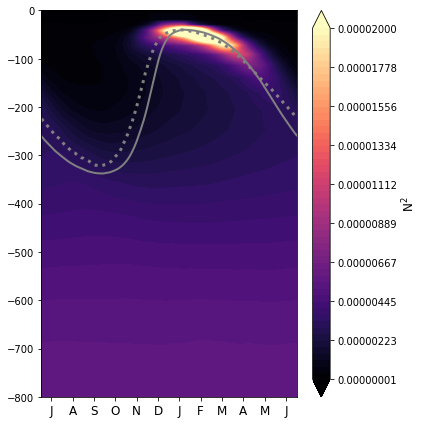

In [18]:
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig, ax = plt.subplots(figsize=(6,6))
fig.set_tight_layout(True)
im = ax.contourf(range(360), N2day.Zp1, N2day.roll(days=-180).T,
                levels=1e-5*np.linspace(.001,2,55), extend='both',
#                   vmin=1e-8, vmax=1e-5, 
                cmap='magma')
ax.plot(range(360), MLDTday.roll(days=-180), color='grey', lw=2)
# ax.plot(range(360), MLDN2day.roll(days=-180), color='w', lw=3, ls='--')
ax.plot(range(360), -MXLDday.roll(day=-180), color='grey', lw=3, ls=':')
# ax.plot(range(360), -KPPMLDday.roll(day=-180), color='w', lw=3, ls='-.')
ax.set_ylim([-8e2,0.])
ax.set_xlim([0.,359])
ax.set_xticks(np.linspace(14,344,12))
ax.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"N$^2$", fontsize=12)
plt.savefig(op.join(ddir,'Figures/N2-MXLD_20km.pdf'))

In [8]:
theta = dsave.THETA
theta.coords['months'] = ('time',np.tile(np.repeat(range(12),30),dy))
with ProgressBar():
    theta_mon = theta.sel(YC=slice(6e5,14e5)).groupby('months').mean(['time','YC','XC']).compute()
theta_mon

[########################################] | 100% Completed |  7min 23.1s


<xarray.DataArray 'THETA' (months: 12, Z: 40)>
array([[ 4.172609,  4.169888,  4.166197, ..., -0.135838, -0.150927, -0.154946],
       [ 4.286386,  4.284827,  4.28312 , ..., -0.135982, -0.150903, -0.154892],
       [ 4.226049,  4.225442,  4.224909, ..., -0.135772, -0.150732, -0.154733],
       ...,
       [ 3.643191,  3.642942,  3.642776, ..., -0.133746, -0.14886 , -0.153024],
       [ 3.722206,  3.721008,  3.720069, ..., -0.133602, -0.148668, -0.152636],
       [ 3.922532,  3.919978,  3.916969, ..., -0.133521, -0.148501, -0.152433]],
      dtype=float32)
Coordinates:
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 16.0 19.0 22.0 26.0 30.0 36.0 ...
    PHrefC   (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 799.515 ...
  * months   (months) int64 0 1 2 3 4 5 6 7 8 9 10 11

[Text(0,0,'J'),
 Text(0,0,'F'),
 Text(0,0,'M'),
 Text(0,0,'A'),
 Text(0,0,'M'),
 Text(0,0,'J'),
 Text(0,0,'J'),
 Text(0,0,'A'),
 Text(0,0,'S'),
 Text(0,0,'O'),
 Text(0,0,'N'),
 Text(0,0,'D')]

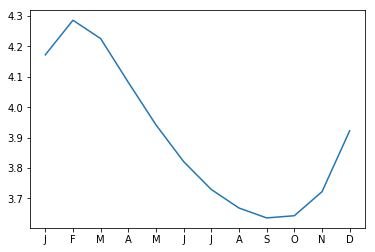

In [9]:
fig,ax = plt.subplots()
ax.plot(range(1,13), theta_mon[:,0])
ax.set_xticks(range(1,13))
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

In [10]:
u1D = dsave.UVEL
v1D = dsave.VVEL

In [8]:
dsnap.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
dsave.coords['seas'] = ('time',np.tile(np.repeat(range(4),90),dy))
dseas = dsave.groupby('seas').mean(['time','XC','XG'])
dsano = dsnap.groupby('seas') - dseas
with ProgressBar():
    dsano.load()
dsano

[########################################] | 100% Completed |  6min 24.2s


<xarray.Dataset>
Dimensions:  (XC: 50, XG: 50, YC: 100, YG: 100, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 480)
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG       (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu       (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 400000000.0 400000000.0 400000000.0 400000000.0 ...
    dxG      (YG, XC) >f4 20000.0 20000.0 20000.0 20000.0 20000.0 20000.0 ...
    dyG      (YC, XG) >f4 20000.0 20000.0 20000.0 20000.0 20000.0 20000.0 ...
    Depth    (YC, XC)

In [9]:
up = dsano.UVEL
vp = dsano.VVEL
wp = dsano.WVEL
phip = dsano.PHIHYD

In [10]:
grid = Grid(dsnap, periodic=['X'])
bp = grid.diff(phip,'Z',boundary='fill')/grid.diff(phip.Z,'Z',boundary='fill')
# wpphip = grid.interp(wp,'Z',boundary='fill')*phip
# wpphip_z = grid.diff(wpphip,'Z',boundary='fill')/grid.diff(wpphip.Z,'Z',boundary='fill')
wpbp = wp*bp
# wpphip_z
wpbp

<xarray.DataArray (time: 480, Zl: 40, YC: 100, XC: 50)>
array([[[[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [ 3.651875e-09, ...,  3.738343e-09]],

        ...,

        [[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [ 1.573558e-12, ..., -9.257247e-11]]],


       ...,


       [[[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [-5.227444e-09, ..., -5.170507e-09]],

        ...,

        [[-0.000000e+00, ..., -0.000000e+00],
         ...,
         [-2.869152e-11, ..., -8.928063e-12]]]], dtype=float32)
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA       (YC, XC) >f4 400000000.0 400000000.0 400000000.0 400000000.0 ...
    Depth    (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    iter     (time) int64 2488320 2489400 2490480 2491

In [11]:
wpbp.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
wpbp.coords['days'] = ('time',np.tile(range(24),dy))
wpbp.to_dataset(name='wpbp').to_netcdf(op.join(ddir,'APEconversion_20km.nc'))

In [17]:
with ProgressBar():
    wpbpd = xr.open_dataset(op.join(ddir,'APEconversion_20km.nc')
                          ).wpbp.sel(YC=slice(6e5,14e5)).groupby('days').mean(['time','YC','XC']).compute()
wpbpd

<xarray.DataArray 'wpbp' (days: 24, Zl: 40)>
array([[-4.879377e-10,  4.319233e-10,  7.785458e-10, ...,  3.867451e-10,
         1.908764e-10,  9.985195e-11],
       [-6.167477e-10,  3.777636e-10,  6.748421e-10, ...,  3.720008e-10,
         1.818765e-10,  9.668205e-11],
       [-1.562463e-09,  4.244594e-10,  7.717481e-10, ...,  3.831086e-10,
         1.881052e-10,  1.028213e-10],
       ...,
       [ 2.794379e-10,  9.276243e-10,  1.747867e-09, ...,  3.652191e-10,
         1.806369e-10,  9.523243e-11],
       [-2.077086e-10,  7.304122e-10,  1.359712e-09, ...,  3.674465e-10,
         1.868114e-10,  1.050825e-10],
       [-7.391135e-10,  5.253695e-10,  9.549396e-10, ...,  3.486413e-10,
         1.701086e-10,  8.876732e-11]], dtype=float32)
Coordinates:
  * Zl       (Zl) float32 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * days     (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


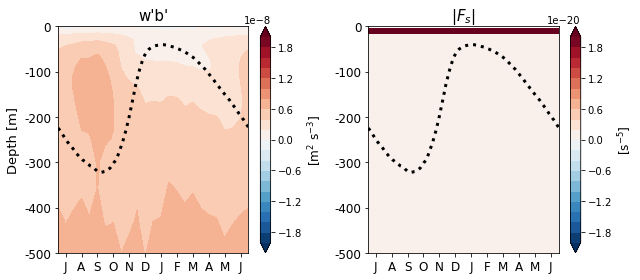

In [23]:
nys, nyn = (6e5,14e5)
month = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
fig.set_tight_layout(True)
im1 = ax1.contourf(np.linspace(0,345,24), wpbpd.Zl, wpbpd.T.roll(days=-12), 
                  levels=1e-8*np.linspace(-2,2.,21), 
                   extend='both', cmap='RdBu_r')
ax1.contourf(np.linspace(14,359,24), wpbpd.Zl, wpbpd.T.roll(days=-13), 
            levels=1e-8*np.linspace(-2,2.,21), 
            extend='both', cmap='RdBu_r')
im2 = ax2.contourf(np.linspace(0,345,24), Fsd.Z, Fsd.T.roll(day=-12), 
                  levels=1e-20*np.linspace(-2,2,21), 
                  cmap='RdBu_r', extend='both')
ax2.contourf(np.linspace(14,359,24), Fsd.Z, Fsd.T.roll(day=-13), 
            levels=1e-20*np.linspace(-2,2,21), 
            cmap='RdBu_r', extend='both')
ax1.plot(range(360), -MXLDday.roll(day=-180), 
        ls=':', lw=3, color='k')
ax2.plot(range(360), -MXLDday.roll(day=-180), 
        ls=':', lw=3, color='k')
ax1.set_ylim([-5e2,0])
ax1.set_xlim([0.,359.])
ax2.set_ylim([-5e2,0])
ax2.set_xlim([0.,359.])
ax1.set_title(r"w'b'", fontsize=15)
ax2.set_title(r"|$F_s$|", fontsize=15)
ax1.set_xticks(np.linspace(14,344,12))
ax1.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax2.set_xticks(np.linspace(14,344,12))
ax2.set_xticklabels(np.roll(np.array(month),-6), fontsize=12)
ax1.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax2.set_yticklabels(np.array([-500,-400,-300,-200,-100,0]), fontsize=12)
ax1.set_ylabel(r"Depth [m]", fontsize=13)
# ax2.set_xlabel(r"Month", fontsize=13)
# fig.subplots_adjust(right=0.88)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar1.set_label(r"[m$^{2}$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[s$^{-5}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figures/wb-Fs_20km.pdf'))

In [5]:
# dsKPP = open_mdsdataset(op.join(ddir,'Phys-only_20km'), grid_dir=op.join(ddir,'20km_grid'),
#                        iters=range(ts+72,te+72,72), prefix=['KPPboundary'], delta_t=dt
#                        )
# dsKPP

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/Phys-only_20km. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:   (XC: 50, XG: 50, YC: 100, YG: 100, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 3600)
Coordinates:
  * XC        (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC        (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG        (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG        (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA        (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dxG       (YG, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dyG       (YC, XG) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    Depth     (YC

In [17]:
# hbl = dsave.KPPhbl
# MLD = dsave.MXLDEPTH
# hbl99 = xr.DataArray(np.percentile(hbl, 99, axis=-1), dims=['time','YC'],
#                     coords={'time':dsave.time.data,'YC':dsave.YC.data})
# month = np.tile(np.repeat(range(12),30),dy)
# day = np.tile(range(360),dy)
# MLD.coords['month'] = ('time',month)
# MLD.coords['day'] = ('time',day)
# MLD.to_dataset(name='mld').to_netcdf(op.join(ddir,'KPPMLD_20km.nc'))

hbl99.coords['month'] = ('time',month)
hbl99.coords['day'] = ('time',day)
hbl99.to_dataset(name='hbl99').to_netcdf(op.join(ddir,'KPPhbl_99percentile_20km.nc'))
with ProgressBar():
    hbl99_mon = hbl99.groupby('month').mean('time').compute()
    hbl99_day = hbl99.groupby('day').mean('time').compute()
hbl99_mon

<xarray.DataArray (month: 12, YC: 100)>
array([[  0.      , 846.670634, 714.554756, ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 824.613972, 703.51526 , ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 807.871706, 686.389166, ...,  30.      ,  30.      ,
         30.      ],
       ...,
       [  0.      , 830.498927, 770.851675, ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 827.580594, 754.23196 , ...,  30.      ,  30.      ,
         30.      ],
       [  0.      , 854.556244, 750.495598, ...,  30.      ,  30.      ,
         30.      ]])
Coordinates:
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11

[Text(0,0,'J'),
 Text(0,0,'F'),
 Text(0,0,'M'),
 Text(0,0,'A'),
 Text(0,0,'M'),
 Text(0,0,'J'),
 Text(0,0,'J'),
 Text(0,0,'A'),
 Text(0,0,'S'),
 Text(0,0,'O'),
 Text(0,0,'N'),
 Text(0,0,'D')]

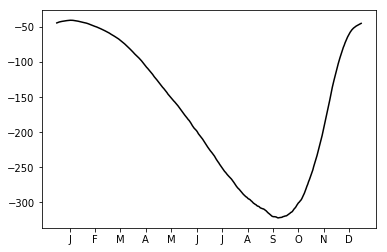

In [18]:
fig, ax = plt.subplots()
ax.plot(range(360), -hbl99_day.sel(YC=slice(6e5,14e5)).mean('YC'), color='k')
ax.set_xticks(range(15,360,30))
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

In [19]:
with ProgressBar():
    uk2 = xrft.power_spectrum(grid.interp(up,'X').sel(YC=slice(6e5,1.4e6)
                                                     )[:,::2].chunk(chunks={'XC':100}),
                             dim=['XC'], detrend='constant').compute()
    vk2 = xrft.power_spectrum(grid.interp(vp,'Y',boundary='fill').sel(YC=slice(6e5,1.4e6)
                                                                     )[:,::2].chunk(chunks={'XC':100}),
                             dim=['XC'], detrend='constant').compute()

ekek = (uk2 + vk2)
ekek

[###                                     ] | 9% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2.2s
[###                                     ] | 9% Completed |  0.1s

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2.0s


<xarray.DataArray (time: 480, Z: 20, YC: 40, freq_XC: 50)>
array([[[[1.534273e-01, ..., 9.618150e-03],
         ...,
         [1.599345e-01, ..., 5.105389e-02]],

        ...,

        [[1.377247e-05, ..., 5.628532e-04],
         ...,
         [2.290380e-03, ..., 7.422658e-04]]],


       ...,


       [[[2.087897e-03, ..., 6.267798e-03],
         ...,
         [2.792234e-01, ..., 3.624369e-01]],

        ...,

        [[2.236168e-07, ..., 1.546346e-04],
         ...,
         [5.338524e-04, ..., 2.526881e-03]]]])
Coordinates:
  * time             (time) float64 2.986e+09 2.987e+09 2.989e+09 2.99e+09 ...
  * Z                (Z) >f4 -5.0 -25.0 -49.0 -81.5 -126.0 -187.0 -272.0 ...
  * YC               (YC) >f4 610000.0 630000.0 650000.0 670000.0 690000.0 ...
  * freq_XC          (freq_XC) float64 -2.5e-05 -2.4e-05 -2.3e-05 -2.2e-05 ...
    freq_XC_spacing  float64 1e-06

In [21]:
ekek.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),dy))
ekek.to_dataset(name='eke').to_netcdf(op.join(ddir,'EKEk_20kmrun.nc'))
ekek_seas = ekek.groupby('seas').mean(['time','YC'])
ekek_seas

<xarray.DataArray (seas: 4, Z: 20, freq_XC: 50)>
array([[[0.117527, 0.134124, ..., 0.176531, 0.134124],
        [0.11495 , 0.133009, ..., 0.169922, 0.133009],
        ...,
        [0.000885, 0.001079, ..., 0.001806, 0.001079],
        [0.00131 , 0.001579, ..., 0.003122, 0.001579]],

       [[0.094686, 0.106526, ..., 0.14437 , 0.106526],
        [0.089754, 0.10067 , ..., 0.136534, 0.10067 ],
        ...,
        [0.000635, 0.00081 , ..., 0.001302, 0.00081 ],
        [0.000918, 0.001175, ..., 0.002087, 0.001175]],

       [[0.177558, 0.199   , ..., 0.282858, 0.199   ],
        [0.16956 , 0.189073, ..., 0.269105, 0.189073],
        ...,
        [0.000886, 0.001174, ..., 0.00183 , 0.001174],
        [0.001304, 0.00168 , ..., 0.003077, 0.00168 ]],

       [[0.147231, 0.156986, ..., 0.225961, 0.156986],
        [0.139637, 0.148079, ..., 0.21265 , 0.148079],
        ...,
        [0.000654, 0.000818, ..., 0.001353, 0.000818],
        [0.000955, 0.00119 , ..., 0.00218 , 0.00119 ]]])
Coordinates

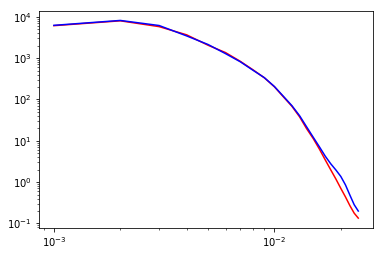

In [22]:
fig, ax = plt.subplots()
ax.plot(ekek_seas.freq_XC[26:]*1e3, ekek_seas[0,0,26:], 'r')
ax.plot(ekek_seas.freq_XC[26:]*1e3, ekek_seas[2,0,26:],'b')
ax.set_xscale('log')
ax.set_yscale('log')

In [23]:
dsSF = open_mdsdataset(op.join(ddir,'Phys-only_20km'),
                      grid_dir=op.join(ddir,'20km_grid'),
                      iters=range(ts+72,te+72,72),
                      prefix=['SF01D'], delta_t=dt
                      )
dsSF

KeyboardInterrupt: 

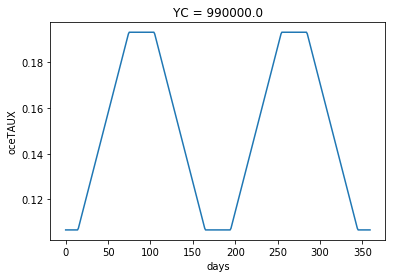

In [26]:
tau = dsSF.oceTAUX
tau.coords['days'] = ('time', np.tile(range(360),dy))
tau[:,49].groupby('days').mean(['time','XG']).plot()

# Energy Transfer
## Spectral

In [25]:
dsadv = open_mdsdataset(op.join(ddir,'MOMadv_20km'), grid_dir=op.join(ddir,'20km_grid'),
                       iters=range(ts,te,1080), prefix=['UVadvsnap'], delta_t=dt
                       )
dsadv

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/MOMadv_20km. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:   (XC: 50, XG: 50, YC: 100, YG: 100, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 240)
Coordinates:
  * XC        (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC        (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG        (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG        (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rA        (YC, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dxG       (YG, XC) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    dyG       (YC, XG) >f4 dask.array<shape=(100, 50), chunksize=(100, 50)>
    Depth     (YC,

In [26]:
dsadv.Um_Advec.attrs

OrderedDict([('standard_name', 'Um_Advec'),
             ('long_name', 'U momentum tendency from Advection terms'),
             ('units', 'm/s^2'),
             ('mate', 'Vm_Advec')])

In [27]:
with ProgressBar():
    uuadv = xrft.cross_spectrum(grid.interp(u,'X').sel(YC=slice(6e5,14e5)), 
                                grid.interp(dsadv.Um_Advec,'X').sel(YC=slice(6e5,14e5)),
                                dim=['XC'], detrend='constant').compute()
    vvadv = xrft.cross_spectrum(grid.interp(v,'Y',boundary='fill').sel(YC=slice(6e5,14e5)), 
                                grid.interp(dsadv.Vm_Advec,'Y',boundary='fill').sel(YC=slice(6e5,14e5)),
                                dim=['XC'], detrend='constant').compute()
uuadv

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  6.8s


/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[########################################] | 100% Completed |  2.8s


<xarray.DataArray (time: 120, Z: 40, YC: 40, freq_XC: 50)>
array([[[[ 1.084202e-16, ...,  5.803220e-09],
         ...,
         [ 1.219727e-16, ...,  2.173615e-09]],

        ...,

        [[-1.242456e-26, ...,  4.183124e-11],
         ...,
         [ 8.300923e-18, ..., -7.164558e-11]]],


       ...,


       [[[-1.517883e-16, ...,  1.124930e-08],
         ...,
         [-2.602085e-16, ...,  6.191827e-09]],

        ...,

        [[ 8.809143e-18, ...,  1.967097e-11],
         ...,
         [ 3.049319e-18, ...,  1.176491e-10]]]])
Coordinates:
  * time             (time) float64 2.986e+09 2.989e+09 2.991e+09 2.994e+09 ...
  * Z                (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * YC               (YC) >f4 610000.0 630000.0 650000.0 670000.0 690000.0 ...
  * freq_XC          (freq_XC) float64 -2.5e-05 -2.4e-05 -2.3e-05 -2.2e-05 ...
    freq_XC_spacing  float64 1e-06

In [28]:
spectran = uuadv + vvadv
spectran

<xarray.DataArray (time: 120, Z: 40, YC: 40, freq_XC: 50)>
array([[[[-5.255424e-07, ...,  5.243099e-07],
         ...,
         [-1.674782e-06, ...,  4.487669e-07]],

        ...,

        [[-2.596279e-09, ...,  3.994823e-09],
         ...,
         [ 7.291239e-09, ...,  7.158277e-09]]],


       ...,


       [[[-4.956787e-07, ...,  1.320461e-06],
         ...,
         [ 4.762089e-07, ...,  5.526663e-06]],

        ...,

        [[-1.789007e-09, ..., -1.901399e-09],
         ...,
         [-3.528089e-10, ..., -1.015463e-08]]]])
Coordinates:
  * time             (time) float64 2.986e+09 2.989e+09 2.991e+09 2.994e+09 ...
  * Z                (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * YC               (YC) >f4 610000.0 630000.0 650000.0 670000.0 690000.0 ...
  * freq_XC          (freq_XC) float64 -2.5e-05 -2.4e-05 -2.3e-05 -2.2e-05 ...
    freq_XC_spacing  float64 1e-06

In [76]:
specKEflux = (-(spectran*spectran.freq_XC)[:,:,:,26:].cumsum(axis=-1) 
              + (spectran*spectran.freq_XC)[:,:,:,26:].sum(axis=-1).data[:,:,:,np.newaxis])
specKEflux

<xarray.DataArray (time: 240, Z: 40, YC: 40, freq_XC: 24)>
array([[[[ 2.241813e-08, ...,  0.000000e+00],
         ...,
         [ 6.189096e-08, ...,  0.000000e+00]],

        ...,

        [[-2.201424e-09, ...,  0.000000e+00],
         ...,
         [-6.999537e-09, ...,  0.000000e+00]]],


       ...,


       [[[-1.212532e-07, ...,  0.000000e+00],
         ...,
         [-4.525893e-08, ...,  0.000000e+00]],

        ...,

        [[ 2.908647e-09, ...,  0.000000e+00],
         ...,
         [ 3.026046e-09, ...,  0.000000e+00]]]])
Coordinates:
  * time             (time) float64 2.115e+09 2.116e+09 2.118e+09 2.119e+09 ...
  * Z                (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * YC               (YC) >f4 610000.0 630000.0 650000.0 670000.0 690000.0 ...
  * freq_XC          (freq_XC) float64 1e-06 2e-06 3e-06 4e-06 5e-06 6e-06 ...
    freq_XC_spacing  float64 1e-06

In [77]:
specKEflux.coords['seas'] = ('time',np.tile(np.repeat(range(4),6),10))
specKE_seas = specKEflux.sel(YC=slice(6e5,14e5)).groupby('seas').mean(['time','YC']).compute()
specKE_clim = specKEflux.sel(YC=slice(6e5,14e5)).mean(['time','YC']).compute()
specKE_seas

<xarray.DataArray (seas: 4, Z: 40, freq_XC: 24)>
array([[[-1.083374e-08, -1.258382e-08, ...,  3.877646e-11,  0.000000e+00],
        [-1.159763e-08, -1.337991e-08, ...,  3.932403e-11,  0.000000e+00],
        ...,
        [-5.780700e-10, -7.086897e-10, ...,  1.600652e-13,  0.000000e+00],
        [ 2.625612e-09,  2.196217e-09, ...,  2.644390e-13,  0.000000e+00]],

       [[ 2.461402e-09, -3.467581e-10, ...,  2.731046e-11,  0.000000e+00],
        [ 1.005634e-09, -1.725774e-09, ...,  2.736903e-11,  0.000000e+00],
        ...,
        [-1.653042e-10, -1.643432e-10, ...,  4.502104e-14,  0.000000e+00],
        [ 2.804301e-09,  2.508927e-09, ...,  8.181696e-14,  0.000000e+00]],

       [[ 8.223284e-09,  3.489053e-09, ...,  4.690604e-11,  0.000000e+00],
        [ 6.107603e-09,  1.542980e-09, ...,  4.736887e-11,  0.000000e+00],
        ...,
        [-1.906117e-10, -4.496029e-10, ...,  2.398673e-13,  0.000000e+00],
        [ 3.139586e-09,  2.569302e-09, ...,  4.147081e-13,  0.000000e+00]],

      

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


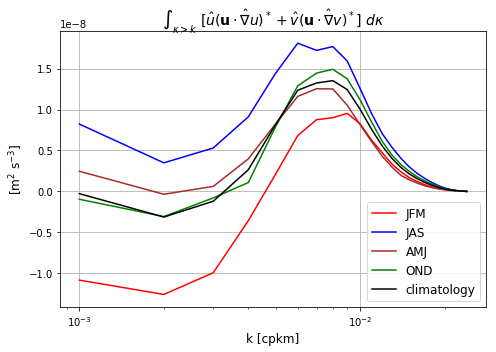

In [79]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
ax.plot(specKE_seas.freq_XC*1e3, specKE_seas[0,0], 'r', label=r'JFM')
ax.plot(specKE_seas.freq_XC*1e3, specKE_seas[2,0],'b', label=r'JAS')
ax.plot(specKE_seas.freq_XC*1e3, specKE_seas[1,0], color='brown', label=r'AMJ')
ax.plot(specKE_seas.freq_XC*1e3, specKE_seas[3,0],'g', label=r'OND')
ax.plot(specKE_clim.freq_XC*1e3, specKE_clim[0],'k', label=r'climatology')
ax.set_xscale('log')
# ax.set_yscale('symlog', linthreshy=1e-8)
ax.set_xlabel(r'k [cpkm]',fontsize=12)
ax.set_ylabel(r'[m$^2$ s$^{-3}$]',fontsize=12)
ax.legend(loc='lower right',fontsize=12)
ax.set_title(r"$\int_{\kappa>k}\ [\hat{u}\hat{({\bf u}\cdot \nabla u)}^*+\hat{v}\hat{({\bf u}\cdot \nabla v)}^*]\ d\kappa$",
            fontsize=14)
ax.grid(True)

## Structure Functional

In [84]:
Ttave = dsave.THETA
Ttave.coords['seas'] = ('time',np.repeat(np.tile(range(4),90),10))
Ttave_seas = Ttave.groupby('seas').mean(['time','XC'])
g = 9.81
alpha = 2e-4
with ProgressBar():
    N2 = grid.interp(alpha*g * grid.diff(Ttave_seas,'Z',boundary='fill')
                    / grid.diff(Ttave_seas.Z,'Z',boundary='fill'),
                    'Z',boundary='fill').compute()

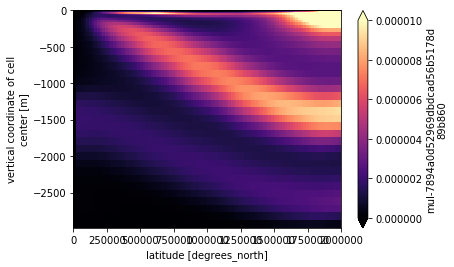

In [85]:
N2.mean('seas').plot(vmax=1e-5, vmin=0., cmap='magma')

In [100]:
N = bp.shape
rg = np.arange(1,int(.5*N[-1]),2)
res = 2e1
print(res*rg)
us = np.zeros((4, len(rg), len(dsnap.Z)))
vs = np.zeros((4, len(rg), len(dsnap.Z)))
ws = np.zeros((4, len(rg), len(dsnap.Z)))
bs = np.zeros((4, len(rg), len(dsnap.Z)))
N2mean = N2.sel(YC=slice(6e5,14e5)).mean('YC').compute()

for i in range(len(rg)):
    print(res*rg[i], 'km')
    du = grid.interp(up - up.shift(XG=int(rg[i])), 'X')
    dv = grid.interp(vp - vp.shift(XC=int(rg[i])), 'Y', boundary='fill')
    dw = grid.interp(wp - wp.shift(XC=int(rg[i])), 'Z', boundary='fill')
    db = bp - bp.shift(XC=int(rg[i]))
    du.coords['seas'] = up.seas
    dv.coords['seas'] = vp.seas
    dw.coords['seas'] = wp.seas
    db.coords['seas'] = bp.seas

    us[:,i] = (du**3).sel(YC=slice(6e5,14e5))[:,:,::2,::2].groupby('seas').mean(['time','YC','XC']).compute()
    vs[:,i] = (du*dv**2).sel(YC=slice(6e5,14e5))[:,:,::2,::2].groupby('seas').mean(['time','YC','XC']).compute()
    ws[:,i] = (du*dw**2).sel(YC=slice(6e5,14e5))[:,:,::2,::2].groupby('seas').mean(['time','YC','XC']).compute()
    bs[:,i] = ((du*db**2).sel(YC=slice(6e5,14e5))[:,:,::2,::2].groupby('seas').mean(['time','YC','XC'])
             * N2mean**-1).compute()

V = us + vs
Sl = us
St = vs + ws + bs
print(us,bs)

[ 20.  60. 100. 140. 180. 220. 260. 300. 340. 380. 420. 460.]
20.0 km
60.0 km
100.0 km
140.0 km
180.0 km
220.0 km
260.0 km
300.0 km
340.0 km
380.0 km
420.0 km
460.0 km
[[[ 5.49277456e-06  5.57914836e-06  5.63693402e-06 ... -2.05710464e-07
   -2.19610300e-07 -1.82413757e-07]
  [ 2.37815315e-04  2.39406450e-04  2.39745903e-04 ...  2.40436248e-06
    2.47174080e-06  2.90491607e-06]
  [ 8.99708481e-04  9.03123408e-04  9.02345928e-04 ...  2.26300454e-05
    2.33542632e-05  2.35091356e-05]
  ...
  [-2.54988972e-05 -1.66908994e-05 -1.38692785e-05 ... -3.47555397e-05
   -3.54553413e-05 -3.59656915e-05]
  [-4.48270672e-04 -4.38858115e-04 -4.33734531e-04 ... -5.21966613e-05
   -5.30356810e-05 -5.30023499e-05]
  [-6.66681270e-04 -6.60018006e-04 -6.55133859e-04 ... -6.61773447e-05
   -6.72347160e-05 -6.64843828e-05]]

 [[-1.56348528e-06 -1.53642429e-06 -1.48877541e-06 ...  1.27083197e-07
    1.21356038e-07  1.60536104e-07]
  [ 1.24712649e-04  1.23590056e-04  1.21471399e-04 ...  8.14439954e-06
    

[Text(1,0,'10$^{-13}$'), Text(1,0,'10$^{-12}$')]

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


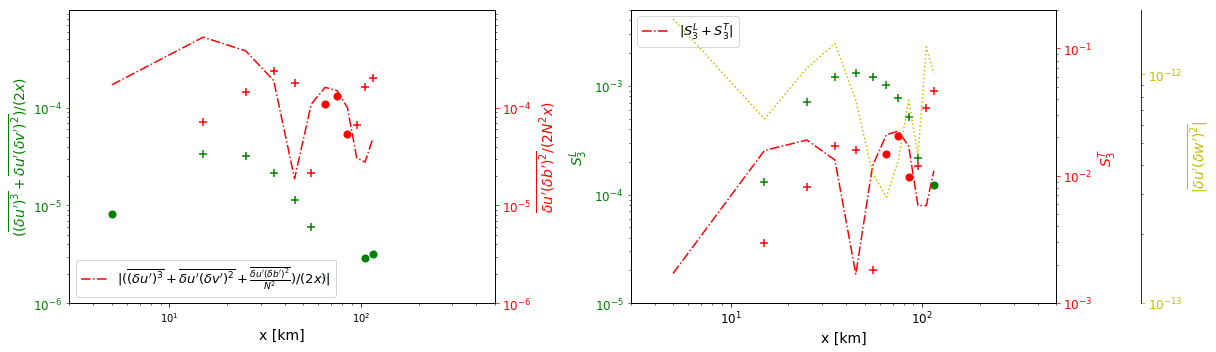

In [115]:
nz = 0 
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(17,5))
fig.set_tight_layout(True)
ax3 = ax1.twinx()
ax4 = ax2.twinx()
ax5 = ax2.twinx()
ax5.spines["right"].set_position(("axes", 1.2))

ax3.plot(5*rg, np.abs((V+bs).mean(axis=0)[:,1]/(2*5*rg)) ,'r-.', 
        label=r"|$(\overline{(\delta u')^3} + \overline{\delta u'(\delta v')^2} + \frac{\overline{\delta u'(\delta b')^2}}{N^2})/(2x)$|"
        )
for i in range(len(rg)):
    if us.mean(axis=0)[i,nz] > 0.:
        ax1.scatter(5*rg[i], V.mean(axis=0)[i,nz]/(2*5*rg[i]), marker='+', c='g', s=60.)
    else:
        ax1.scatter(5*rg[i], np.abs(V.mean(axis=0)[i,nz]/(2*5*rg[i])), marker='o', c='g', s=50.)
    if bs.mean(axis=0)[i,nz] > 0.:
        ax3.scatter(5*rg[i], bs.mean(axis=0)[i,nz]/(2*5*rg[i]), marker='+', c='r', s=60.)
    else:
        ax3.scatter(5*rg[i], np.abs(bs.mean(axis=0)[i,nz]/(2*5*rg[i])), marker='o', c='r', s=50.)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax3.set_yscale('log')
ax1.set_xlim([3,5e2])
ax1.set_ylim([1e-6,1e-3])
ax3.set_ylim([1e-6,1e-3])
# ax2.set_xlim([1,1e3])
ax1.tick_params(axis='y', colors='g')
ax1.set_ylabel(r"$(\overline{(\delta u')^3} + \overline{\delta u'(\delta v')^2})/(2x)$", fontsize=14, color='g')
ax3.tick_params(axis='y', colors='r')
ax3.set_ylabel(r"$\overline{\delta u'(\delta b')^2}/(2N^2x)$", fontsize=14, color='r')
ax1.set_xlabel(r"x [km]", fontsize=14)
ax3.legend(loc='lower left', fontsize=13)
ax1.set_xticks([10,100])
ax1.set_yticks([1e-6,1e-5])
ax1.set_yticks([1e-6,1e-5,1e-4])
ax1.set_yticklabels([r"10$^{-6}$",r"10$^{-5}$",r"10$^{-4}$"],{'fontsize':12})
ax3.set_yticks([1e-6,1e-5,1e-4])
ax3.set_yticklabels([r"10$^{-6}$",r"10$^{-5}$",r"10$^{-4}$"],{'fontsize':12})

ax4.plot(5*rg, np.abs((Sl+St).mean(axis=0)[:,1]) ,'r-.', 
        label=r"|$S_3^L + S_3^T$|"
        )
ax5.plot(5*rg, np.abs((ws).mean(axis=0)[:,1]) ,'y:')
for i in range(len(rg)):
    if Sl.mean(axis=0)[i,nz] > 0.:
        ax2.scatter(5*rg[i], Sl.mean(axis=0)[i,nz], marker='+', c='g', s=60.)
    else:
        ax2.scatter(5*rg[i], np.abs(Sl.mean(axis=0)[i,nz]), marker='o', c='g', s=50.)
    if bs.mean(axis=0)[i,nz] > 0.:
        ax4.scatter(5*rg[i], St.mean(axis=0)[i,nz], marker='+', c='r', s=60.)
    else:
        ax4.scatter(5*rg[i], np.abs(St.mean(axis=0)[i,nz]), marker='o', c='r', s=50.)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax2.set_xlim([3,5e2])
ax2.set_ylim([1e-5,5e-3])
ax4.set_ylim([1e-3,2e-1])
# ax2.set_xlim([1,1e3])
ax2.tick_params(axis='y', colors='g')
ax2.set_ylabel(r"$S_3^L$", fontsize=14, color='g')
ax4.tick_params(axis='y', colors='r')
ax4.set_ylabel(r"$S_3^T$", fontsize=14, color='r')
ax5.tick_params(axis='y', colors='y')
ax5.set_ylabel(r"|$\overline{\delta u'(\delta w')^2}$|", fontsize=14, color='y')
ax2.set_xlabel(r"x [km]", fontsize=14)
ax4.legend(loc='upper left', fontsize=13)
ax2.set_xticks([10,100])
ax2.set_yticks([1e-5,1e-4,1e-3])
ax2.set_xticklabels([r"10$^1$",r"10$^2$"],{'fontsize':12})
ax2.set_yticklabels([r"10$^{-5}$",r"10$^{-4}$",r"10$^{-3}$"],{'fontsize':12})
ax4.set_yticks([1e-3,1e-2,1e-1])
ax4.set_yticklabels([r"10$^{-3}$",r"10$^{-2}$",r"10$^{-1}$"],{'fontsize':12})
ax5.set_yticks([1e-13,1e-12])
ax5.set_yticklabels([r"10$^{-13}$",r"10$^{-12}$"],{'fontsize':12})

# plt.savefig(op.join(ddir,'Figures/KE-PEflux.pdf'))

In [120]:
2.115072000000E+09 + 86400

2115158400.0

In [117]:
2.115158400000E+09/(360*86400)

68.00277777777778